In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png', dpi=200)
sns.set_style('darkgrid')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
import plotly.graph_objects as go

### Gaussian 模型

In [2]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [3]:
# 定义朴素贝叶斯模型
model = AdaBoostClassifier()

# 定义参数网格
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.1, 0.01, 0.001]
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 150]})

In [4]:
# 提取不同参数组合的得分
scores = grid_search.cv_results_["mean_test_score"]

# 提取参数组合列表
param_combinations = [f"n_estimators: {n_est}, learning_rate: {lr}"
                      for n_est in param_grid["n_estimators"]
                      for lr in param_grid["learning_rate"]]

# 绘制调参图像
trace = go.Scatter(x=param_combinations, y=scores, mode="markers")
layout = go.Layout(title="Parameter Tuning for AdaBoost Classifier",
                   xaxis=dict(title="Parameter Combinations"),
                   yaxis=dict(title="Mean Test Score"), font=dict(family='Times New Roman', size=18))
fig = go.Figure(data=[trace], layout=layout)
fig.write_html('Image/4_6_6_1.html')
fig.show()

In [5]:
lr_model = grid_search.best_estimator_
lr_model

AdaBoostClassifier(learning_rate=0.1, n_estimators=150)

In [6]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11190
           1       0.78      0.48      0.60      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.72      0.75     14890
weighted avg       0.83      0.84      0.82     14890



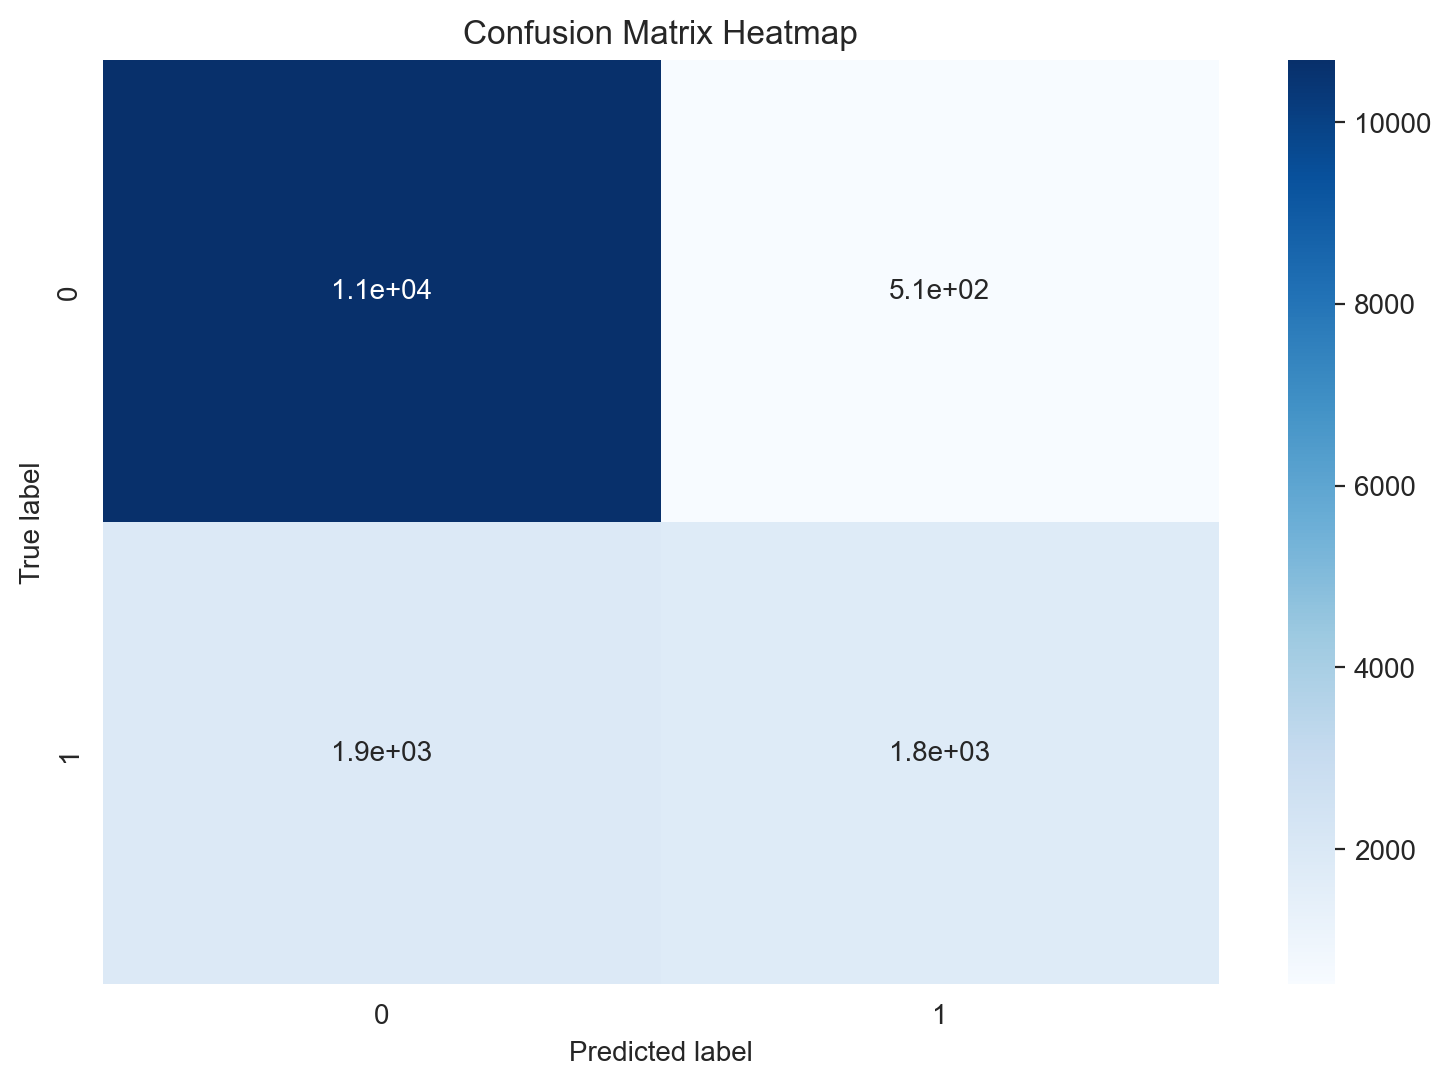

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_6_2.html')
# 显示图表
fig.show()

In [10]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_6_3.html')
fig.show()

### 过采样和欠采样

In [11]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [14]:
# 创建欠采样器
rus = RandomUnderSampler(random_state=42)

# 进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [15]:
lr_model = grid_search.best_estimator_

In [16]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11190
           1       0.78      0.48      0.60      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.72      0.75     14890
weighted avg       0.83      0.84      0.82     14890



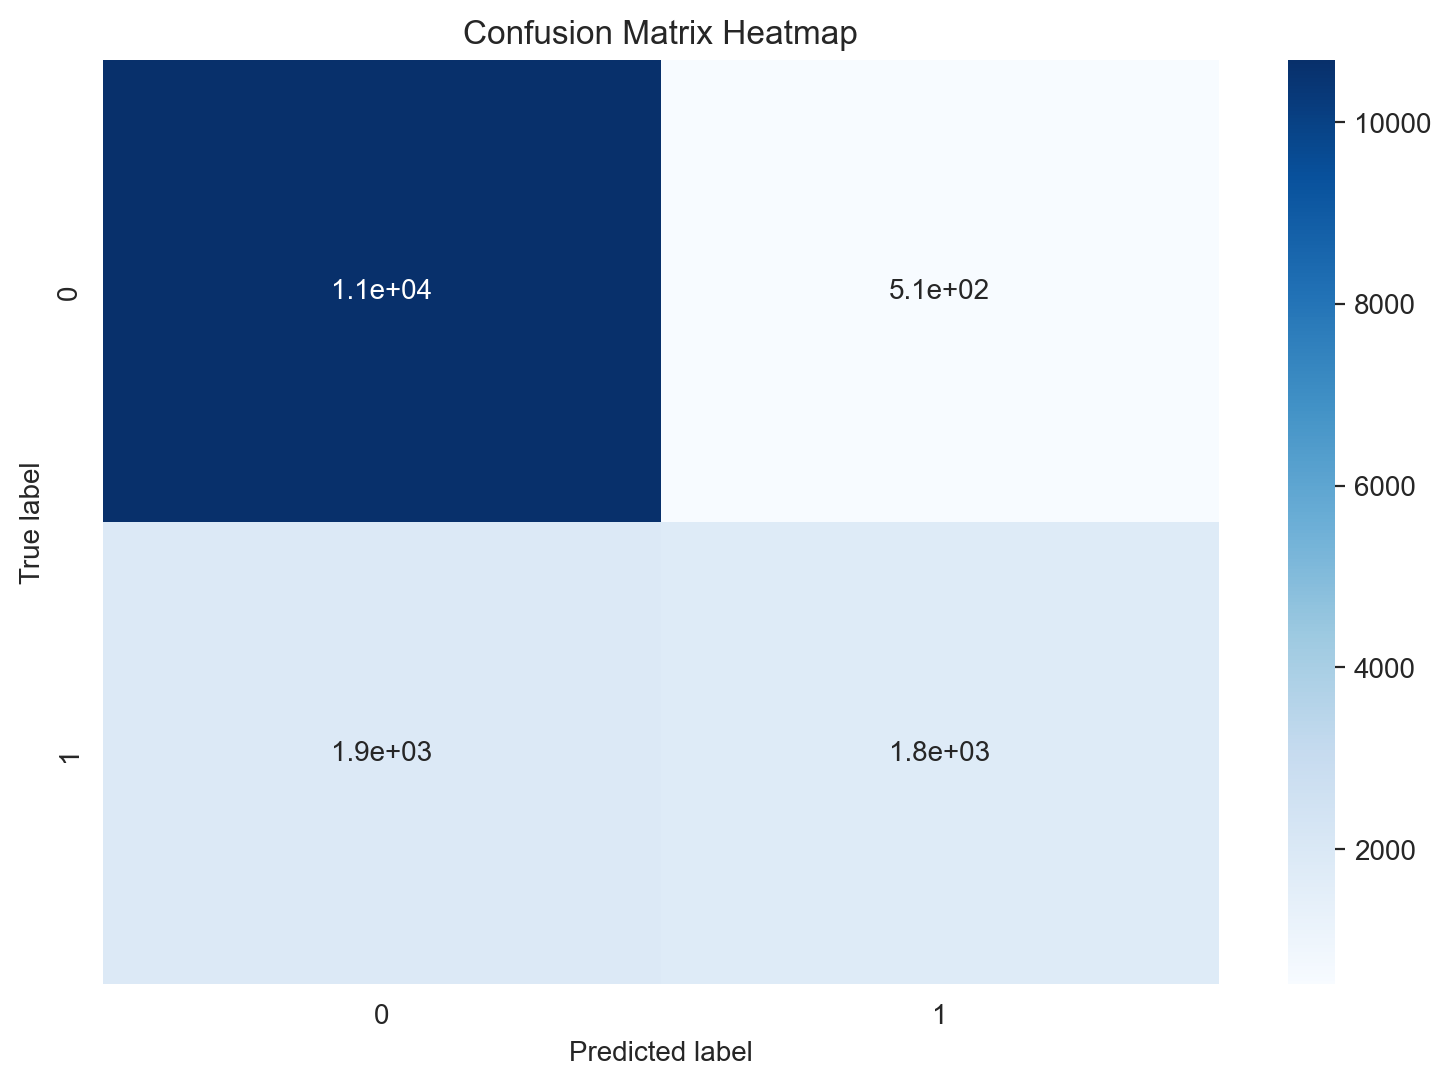

In [18]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [19]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_6_4.html')
# 显示图表
fig.show()

In [20]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_6_5.html')
fig.show()

In [21]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [22]:
from imblearn.over_sampling import RandomOverSampler

In [23]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [24]:
# 创建过采样器
ros = RandomOverSampler(random_state=42)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [25]:
lr_model = grid_search.best_estimator_

In [26]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11190
           1       0.78      0.48      0.60      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.72      0.75     14890
weighted avg       0.83      0.84      0.82     14890



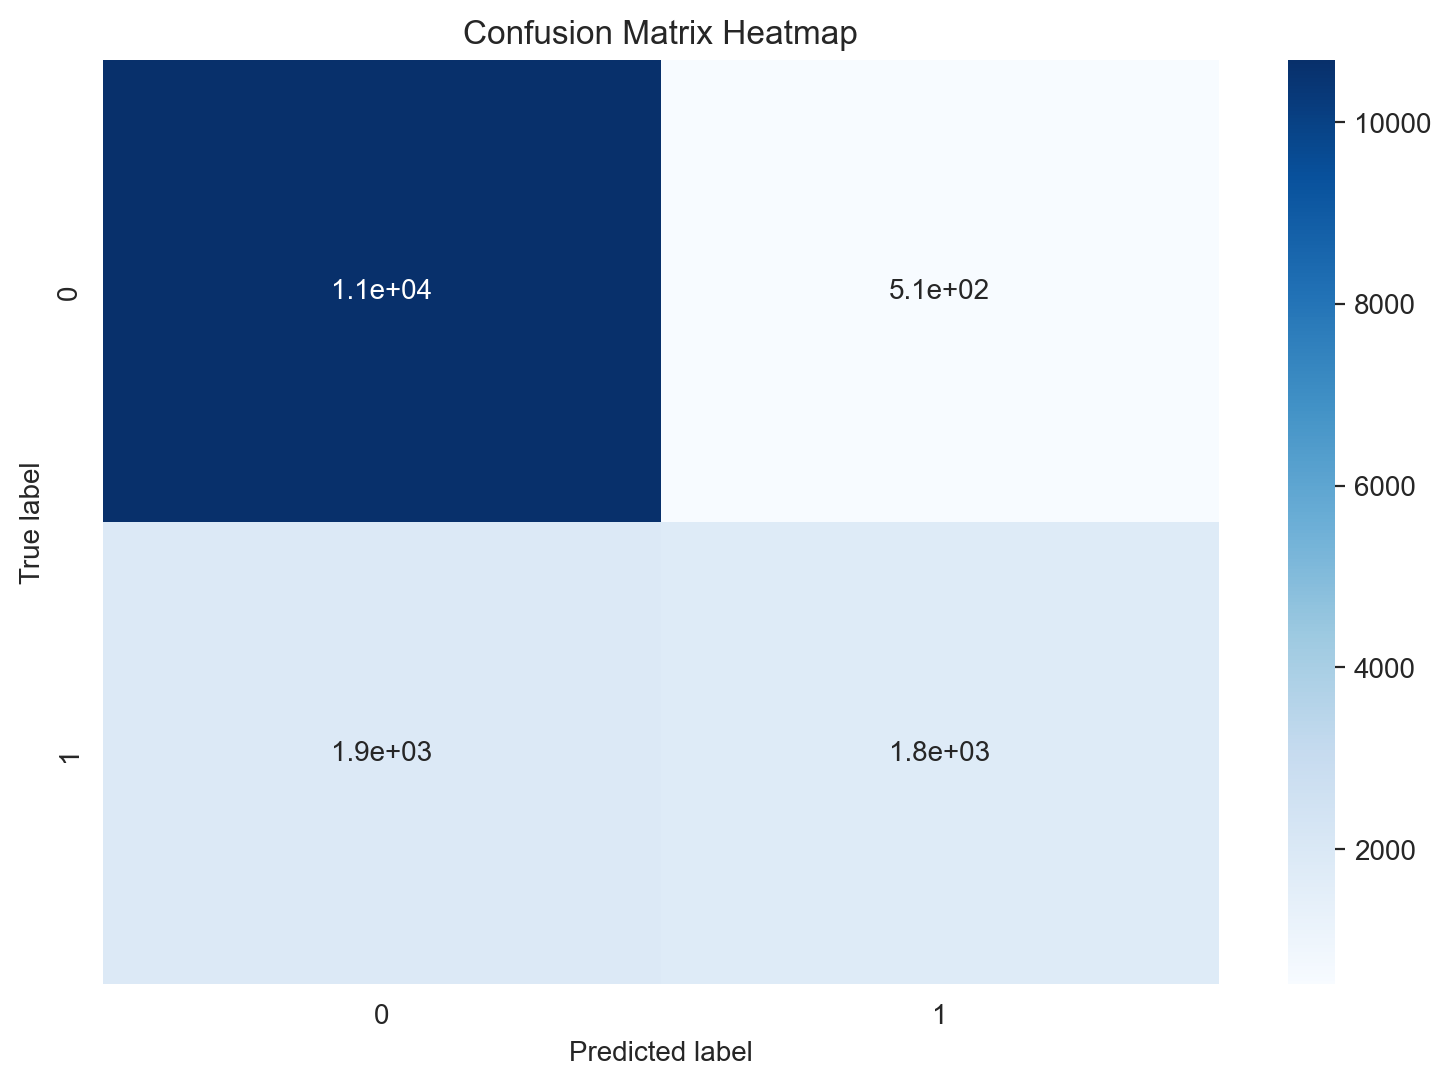

In [28]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [29]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_6_6.html')
# 显示图表
fig.show()

In [30]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_6_7.html')
fig.show()